In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

from load_wastewater_data import load_systems_data

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [32]:
plot_path = f"../plots/wastewater_model/normalization_strategies/PMMoV"
data_output_path = f"../data/PMMoV_normalization"
os.makedirs(os.path.join(plot_path), exist_ok=True)
os.makedirs(os.path.join(data_output_path), exist_ok=True)
# file_name_prefix = f"{substance}_{rain_scenario}_{degradation_setting}"

In [33]:
# define experiment to be preprocessed
experiment_series = "2024_04_03"

substance = "COVID" # COVID
rain_scenario = "Nieselregen" # one of Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [34]:
# Load Data

# for flow normalization
df_KeinRegen = load_systems_data(experiment_series, substance, "KeinRegen", degradation_setting, file_type="concentrations") 
df_Rain = load_systems_data(experiment_series, substance, rain_scenario, degradation_setting, file_type="concentrations") 

df_PMMoV_KeinRegen = load_systems_data(experiment_series, "PMMoV", "KeinRegen", "no_decay", file_type="concentrations") 
df_PMMoV_Rain = load_systems_data(experiment_series, "PMMoV", rain_scenario, "no_decay", file_type="concentrations") 

### Normalisation with PMMoV

copies/l normalized = (copies/l of RNA) * (mean value of the normalization parameter on dry days) / (value of the normalization parameter)

source: https://pubs.acs.org/doi/10.1021/acsestwater.2c00306


#### Apply normalization of PMMoV values

In [ ]:
# normalize w.r.t. PMMoV values
mean_values = df_PMMoV_KeinRegen.groupby(["sampling_point", "memilio_id"])["copies/l"].mean().reset_index().rename(columns={"copies/l": "mean_copies/l"})
df_PMMoV_Rain = pd.merge(df_PMMoV_Rain, mean_values, on=["sampling_point", "memilio_id"], how="left")

normalization_factors = df_PMMoV_Rain.loc[:,["time", "sampling_point", "memilio_id"]].copy()
normalization_factors["PMMoV_normalization_factor"] = df_PMMoV_Rain["mean_copies/l"]/df_PMMoV_Rain["copies/l"]

df_Rain = pd.merge(df_Rain.loc[:,["time", "sampling_point", "memilio_id", "copies/l"]], normalization_factors, on=["sampling_point", "memilio_id", "time"], how="inner")
df_Rain["PMMoV_normalized_copies/l"] = df_Rain["copies/l"]*df_Rain["PMMoV_normalization_factor"]
df_Rain.sort_values("time", inplace=True)

#### Store normalized data and calculate metrics

In [36]:
df_Rain.to_csv(os.path.join(data_output_path, f"normalized_{degradation_setting}_{rain_scenario}.csv"), index=False)

Metrics:

absolute error
$|{y_{no-rain}-y_{rain-normalized}}|$

relative error 
$\frac{|{y_{no-rain}-y_{rain-normalized}}|}{y_{no-rain}}$

averaged over all timepoints t

calculated individually per sampling location, simulation id

In [37]:
df_KeinRegen2 = df_KeinRegen[["time", "sampling_point", "memilio_id", "copies/l"]].copy()
df_KeinRegen2.columns = ["time", "sampling_point", "memilio_id", "KeinRegen_copies/l"]

print(df_KeinRegen2.shape)
df_combined = df_Rain.merge(df_KeinRegen2, on=["time", "sampling_point", "memilio_id"], how="outer")
print(df_combined.shape)

(16128000, 4)
(16128000, 7)


In [38]:
# calculate metrics
df_combined["absolute_error_unnormalized"] = np.abs(df_combined["copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["absolute_error"] = np.abs(df_combined["PMMoV_normalized_copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["relative_error_unnormalized"] = df_combined["absolute_error_unnormalized"]/df_combined["KeinRegen_copies/l"]
df_combined["relative_error"] = df_combined["absolute_error"]/df_combined["KeinRegen_copies/l"]

In [39]:
df_metrics = df_combined.groupby(["sampling_point", "memilio_id"]).agg({"absolute_error": "mean", "relative_error": "mean",
                                                                        "absolute_error_unnormalized": "mean", "relative_error_unnormalized": "mean"})

df_metrics["NaNs_KeinRegen"] = df_KeinRegen2.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["copies/l"].isna().sum())

df_metrics.reset_index(inplace=True)
df_metrics.to_csv(os.path.join(data_output_path, f"metrics_{degradation_setting}_{rain_scenario}.csv"), index=False)

/tmp/ipykernel_12231/3923111652.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_KeinRegen"] = df_KeinRegen2.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
/tmp/ipykernel_12231/3923111652.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["copie

In [25]:
metrics_per_sampling_point = df_metrics.groupby("sampling_point").mean().reset_index()[['sampling_point', 'absolute_error', 'relative_error',
       'absolute_error_unnormalized', 'relative_error_unnormalized', 'NaNs_KeinRegen', 'NaNs_Regen']]
metrics_per_sampling_point

#### Subselect specific sampling location

In [26]:
#subselect specific sampling point
sampling_point = "16"

df_KeinRegen = df_KeinRegen.loc[df_KeinRegen.sampling_point==sampling_point, :]
df_Rain = df_Rain.loc[df_Rain.sampling_point==sampling_point, :]
df_PMMoV_KeinRegen = df_PMMoV_KeinRegen.loc[df_PMMoV_KeinRegen.sampling_point==sampling_point, :]
df_PMMoV_Rain = df_PMMoV_Rain.loc[df_PMMoV_Rain.sampling_point==sampling_point, :]

#### Basic Visualization of PMMoV Data

<Axes: xlabel='minutes'>

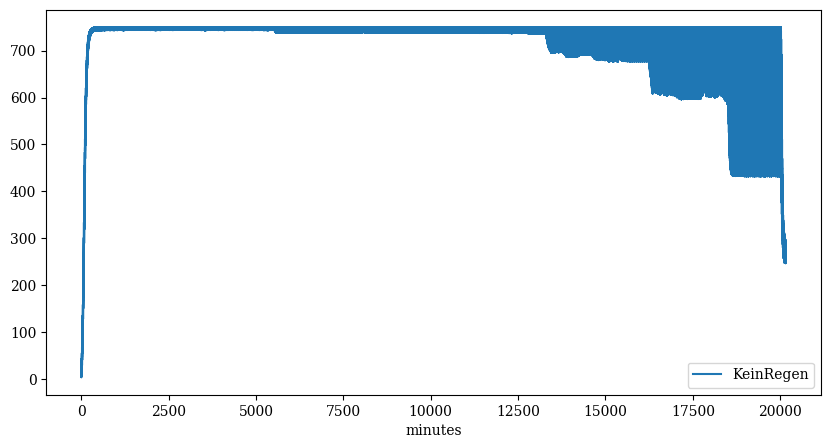

In [27]:
df_PMMoV_KeinRegen.sort_values("minutes", inplace=True)
df_PMMoV_KeinRegen.plot(x="minutes", y="copies/l", label="KeinRegen", figsize=(10, 5))

<Axes: xlabel='minutes'>

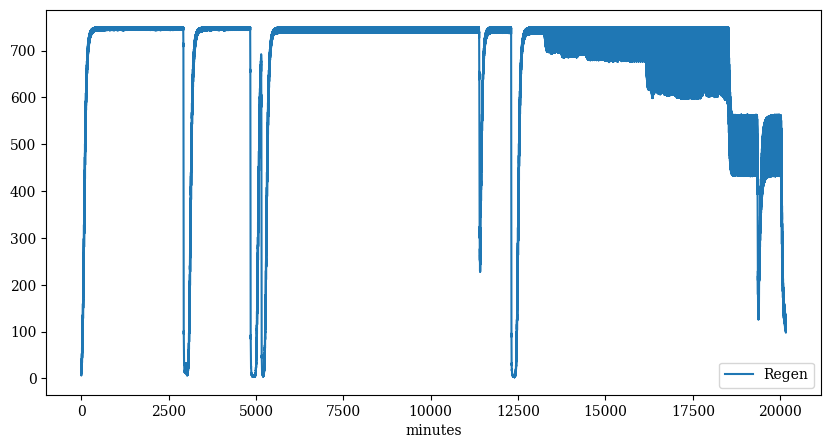

In [28]:
df_PMMoV_Rain.sort_values("minutes", inplace=True)
df_PMMoV_Rain.plot(x="minutes", y="copies/l", label="Regen", figsize=(10, 5))

#### Visualization of Normalization

/tmp/ipykernel_12231/1803107424.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_12231/1803107424.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_12231/1803107424.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


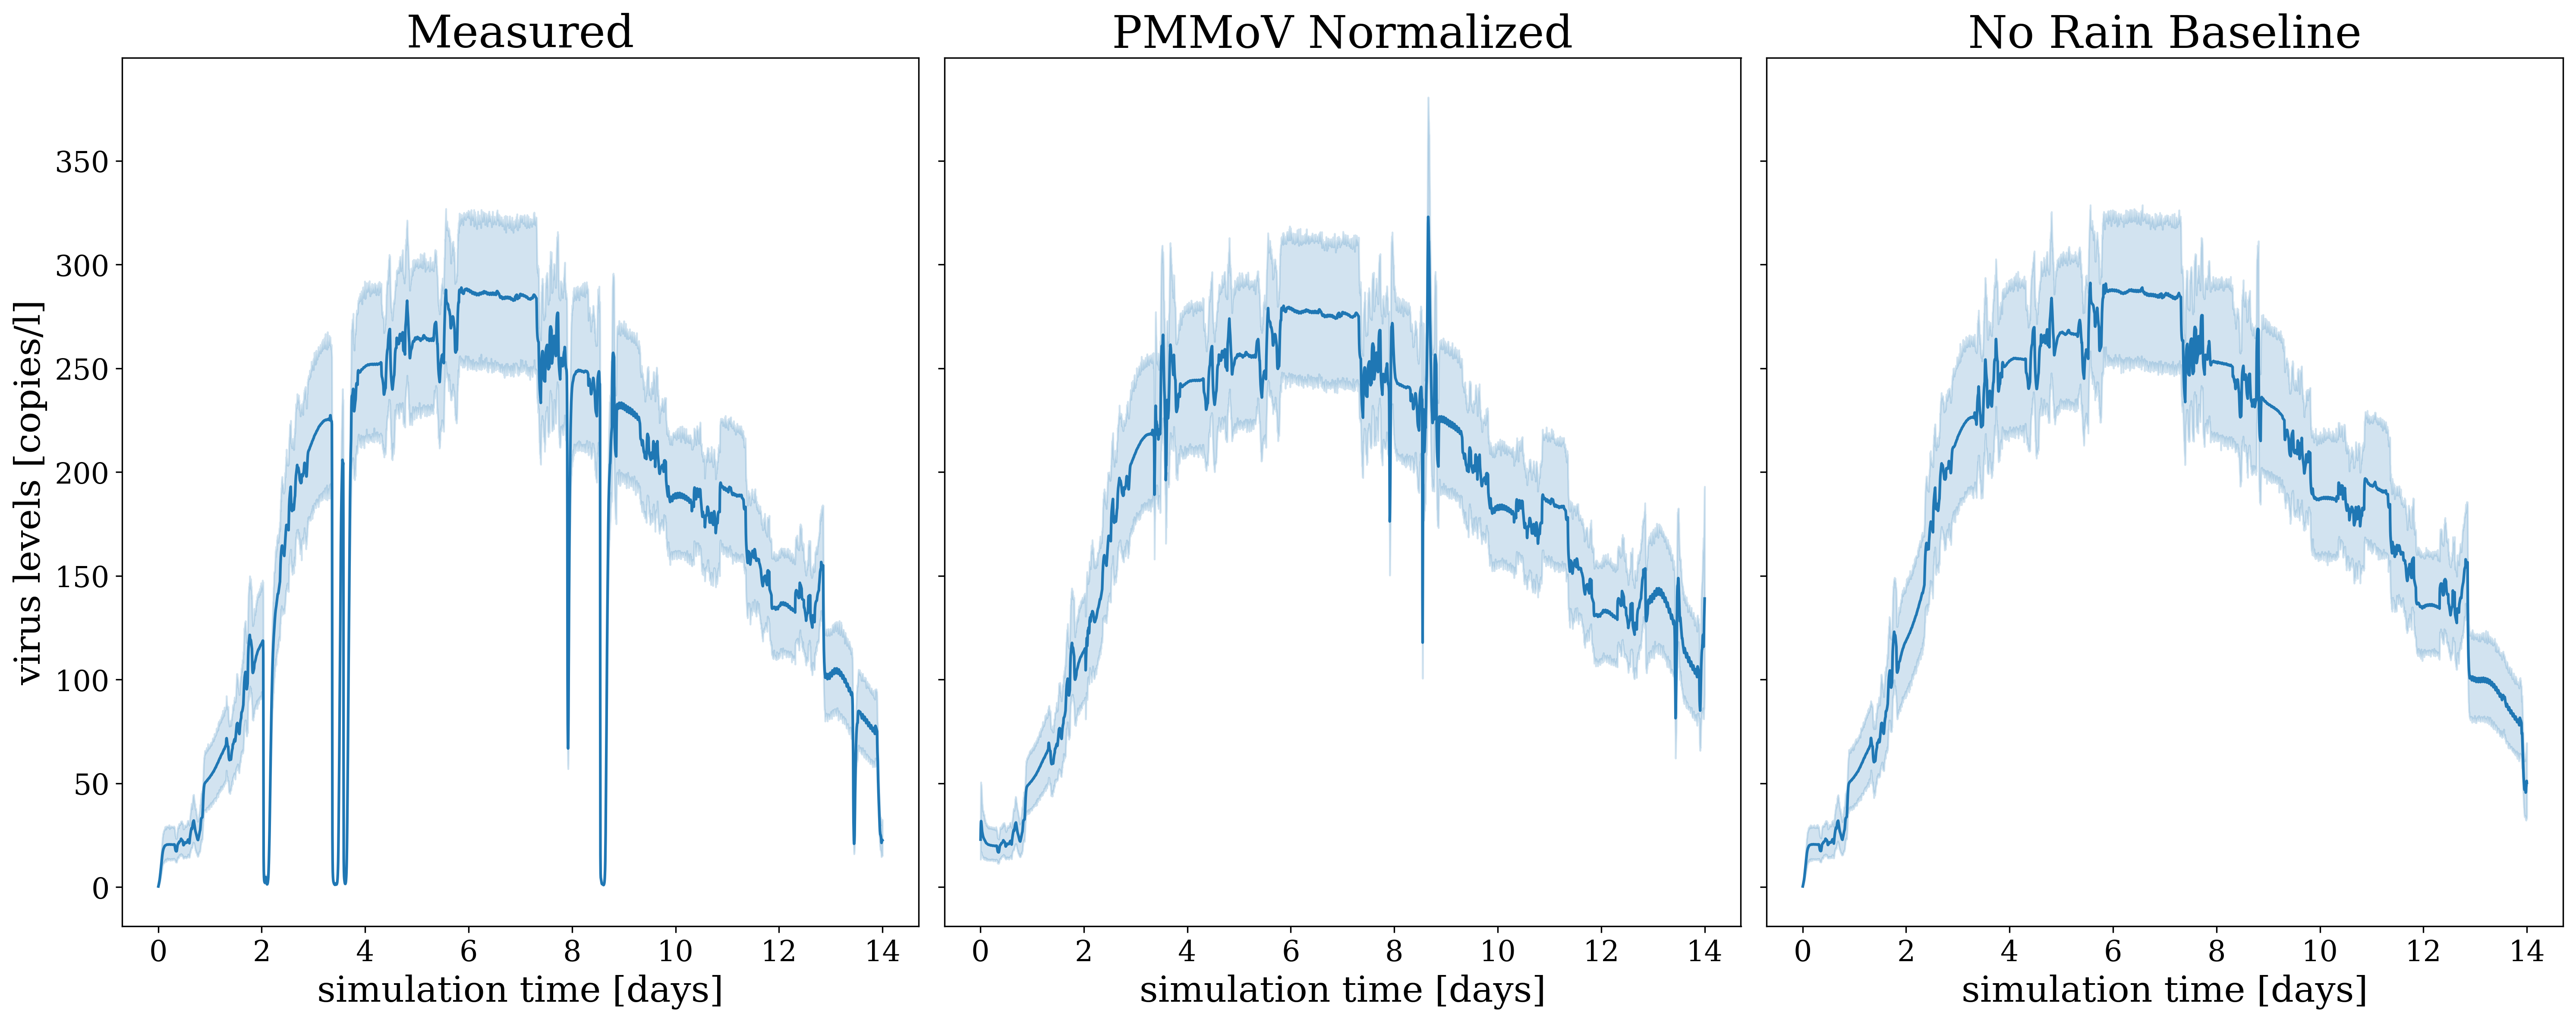

In [29]:
date_form = DateFormatter("%-d")

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 8), dpi=300)

sns.lineplot(df_Rain, x="time", y="copies/l", ax=axs[0])
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_Rain, x="time", y="PMMoV_normalized_copies/l", ax=axs[1])
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("PMMoV Normalized", fontsize=25)    
sns.lineplot(df_KeinRegen, x="time", y="copies/l", ax=axs[2])
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].xaxis.set_major_formatter(date_form) 
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"overview_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}.png"))

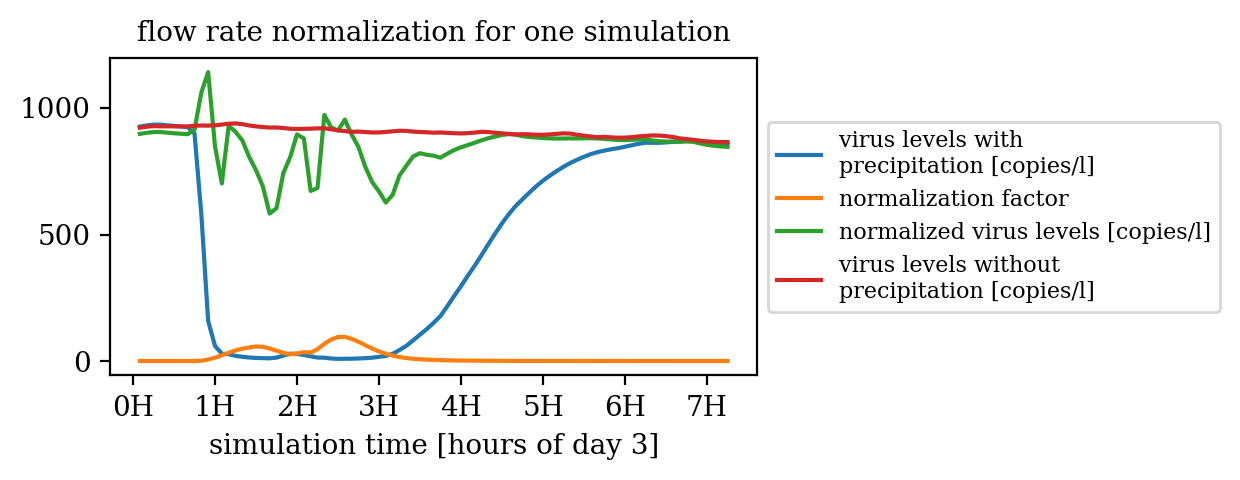

In [30]:
simulation_id = 2

df_Rain['minutes'] = (df_Rain['time'] - df_Rain['time'].min()).dt.total_seconds() // 60
df_KeinRegen['minutes'] = (df_KeinRegen['time'] - df_KeinRegen['time'].min()).dt.total_seconds() // 60

df_sub = df_Rain.loc[df_Rain.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]

fig, axs = plt.subplots(figsize=(6.3,2.5), dpi=200)
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels with\nprecipitation [copies/l]")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalization_factor"], label="normalization factor")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalized_copies/l"], label="normalized virus levels [copies/l]")

df_sub = df_KeinRegen.loc[df_KeinRegen.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels without\nprecipitation [copies/l]")
date_form_2 = DateFormatter("%-HH")
axs.xaxis.set_major_formatter(date_form_2) 
axs.set_xlabel(f"simulation time [hours of day 3]", fontsize=10) # , fontsize=15
# axs.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.title("flow rate normalization for one simulation", fontsize=10)
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"examplary_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}_simulation_{simulation_id}.png"))